# 영화 평점 예측하기

참고 도서: Building ML system with Python

추천 시스템은 온라인 상업 서비스의 중요한 기능입니다.
단순하게 특정 시기에 검색 순위가 상승한 상품을 추천할 수도 있지만,
사용자가 제품 구매 정보를 적극적으로 활용한 고객 입력에 기반한 __협업 필터링(collaborative filtering)__에 대해서 실습해보겠습니다.

넷플릭스의 영화추천 시스템의 성능을 향상시키는 대회가 있었습니다. 기존의 시스템에서 10% 이상 향상시키는 팀에게 백만 달러를 주는 대회였는데 2009년에 어떤 국제팀이 이 대회의 트로피를 가져갔다고 합니다.


현재 넷플릭스 데이터는 사용할 수 없지만 미네소타 대학의 연구소GruopLens에서 제공하는 유사한 특징이 있는 학술데이터를 사용하겠습니다.  10만개의 영화 평점 정보가 있는 5MB 정도의 데이터 입니다.

더 큰 300 MB 의 최근 데이터도 있지만 개인 컴퓨터의 사양을 고려해서 작은 샘플을 다루기로 하겠습니다.



데이터는 아래의 웹 주소에서 다운 받을 수 있습니다.
http://files.grouplens.org/datasets/movielens/


데이터에 대한 설명입니다.

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   
              
10만개의 샘플이 있고 943 명의 사용자가 1682 개의 영화에 대한 평가를 담고 있습니다.
사용자의 취향을 파악할 수 있도록 20 개 이상의 영화에 평점을 준 사용자을 골라서 필터링한 데이터 입니다.
사용자와 영화의 레이블은 1 부터 시작하는데, 나중에 numpy 에서 다룰 때에는 0-base index 로 변환해줍니다.

데이터의

첫 번째 컬럼은 사용자 id

두 번쨰 컬럼은 영화 id

세 번째 컬럼은 추천 점수 (1~5)

네번 쨰 컬럼은 timestamp 인데 사용하지 않는 데이터 입니다.


## raw 데이터 살펴보기

In [260]:
data = np.loadtxt('../data/recommand/ml-100k/u.data')
print('Shape of raw data : ', data.shape)

Shape of raw data :  (100000, 4)


In [261]:
data[0]  # 유저, 영화, 평점, 날짜

array([  1.96000000e+02,   2.42000000e+02,   3.00000000e+00,
         8.81250949e+08])

데이터의 숫자가 지수 표기법으로 나와 있어서 알아보기는 약간 어렵지만 

196, 242, 3, 881250949  입니다.

유저아이디가 196 인 사용자가 영화 242에 준 평점이 3 점입니다. 

## 데이터 로딩


In [262]:
def load():
    import numpy as np
    from scipy import sparse
    data = np.loadtxt('../data/recommand/ml-100k/u.data')
    ij = data[:, :2]
    ij -= 1  # 데이터 시작값을 0 으로 하기 위해서,  원래 데이터는 1 부터 시작한다.
    values = data[:,2]
    reviews = sparse.csc_matrix((values, ij.T)).astype(float)
    return reviews.toarray()

### 데이터를 sparse matrix 로 가공

사용자와 영화가 입력값이고 평점이 출력값(또는 타겟)입니다.

2차원 행렬로 표현하기에 딱 맞는 데이터입니다.


### sparse matrix 만들기의 예

input = [[0,0], [0,1],[1,1]
result = [1,2,3]

인 경우에 위 데이터로 어떤 2차원 매트릭스가 만들어질지 잠시 상상해봅시다.

In [263]:
from scipy import sparse

data = np.array([[0,0],[0,1],[1,1]])
result = np.array([1,2,3])
         
matrix = sparse.csc_matrix((result, data.T))

print('sparse matrix 의 타입과 크기')
print(type(matrix), matrix.shape)

print('sparse matrix 의 간단한 표현')
print(matrix)

print('sparse matrix  를 행렬로 표현')
print(matrix.toarray())

sparse matrix 의 타입과 크기
<class 'scipy.sparse.csc.csc_matrix'> (2, 2)
sparse matrix 의 간단한 표현
  (0, 0)	1
  (0, 1)	2
  (1, 1)	3
sparse matrix  를 행렬로 표현
[[1 2]
 [0 3]]


### 데이터 가공을 하기 위한 추가 데이터 정보 얻기

평점을 준 사용자와 그 영화에 대한 정보를 추출합니다.

사실 처음에 데이터를 로딩할 떄 사용한   ij = data[:, :2]  <- 이 부분처럼 추출해도 되지만 

가공한 데이터에서 데이터를 추출하는 것이 더 의미가 명확합니다.

In [264]:
import numpy as np
reviews = load()
U, M = np.where(reviews)

### np.where(data) 이란

data 안에서 True 인 값을 갖는 (i, j) 위치들을 행 인덱스를 따로 모으고 열 인덱스를 따로 모아서 두 개의 배열로 반환하는 함수 입니다.

예를 들어 [[1,0], [0,1]]  이란 데이터는 (0,0) 과 (1,1) 위치에 True 값을 나타내는 데이터가 있으므로 

np.where([[1,0], [0,1]]) 의 결과는  ([0,1], [0,1]) 입니다.

위에서는 평점이 있는 데이터의 사용자 인덱스를 U 에 저장하고 영화 정보를 M 으로 저장했습니다.

따라서 U 와 M 의 크기는 로딩한 데이터 샘플의 갯수인 100 만개와 일치해야 합니다.

In [265]:
print('Size of valid samples : ',len(U), len(M))

Size of valid samples :  100000 100000


### 영화 평점 테이블 크기 확인

아래의 명령어로 평점 테이블을 크기를 확인하면 행이 유저의 숫자인 943 가 되고 열이 영화의 갯수인 1682 가 됩니다.

이제 어떤 데이터를 다루는지 이미지화 시킬 수 있을 것입니다.

In [266]:
reviews.shape

(943, 1682)

In [267]:
U  # 유저 인덱스   같은 유저는 여러개의 영화에 평점을 주었으므로 같은 인덱스가 반복된다.

array([  0,   0,   0, ..., 942, 942, 942], dtype=int64)

In [268]:
M

array([   0,    1,    2, ..., 1187, 1227, 1329], dtype=int64)

### 데이터 테이블(sparse matrix) 시각화

영화의 평점 점수에 상관없이 데이터가 존재하는 위치(점)을 시각화 해보겠습니다.

matplotlib 의 이미지를 다루는 모듈에 대해서 더 알고 싶다면 아래의 링크에서 정보를 확인해보세요.

https://matplotlib.org/users/image_tutorial.html
https://matplotlib.org/examples/images_contours_and_fields/interpolation_methods.html

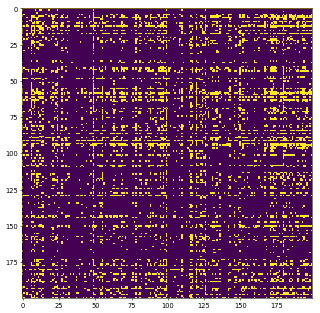

In [269]:
import matplotlib.pyplot as plt

binary = reviews > 0  #  데이터가 존재하는 위치에는 True 나머지 위치에는 False 을 넣은 행렬이 만들어집니다.

# 데이터의 크기가 1과 0밖에 없으므로 이미지가 두 개의 색깔로만 표현됩니다.
# 밝은색 부분이 영화의 평점 데이터가 존재하는 부분입니다.
# 왜 sparse matrix 라고 부르는지 알겠죠

fig = plt.figure(dpi=48,figsize=(8,8))
plt.imshow(binary[:200, :200], interpolation='nearest')  
plt.show()

## ★흥미로운 관찰  x축과 y축 어느 쪽이 영화를 나타내는 축일까?

데이터 이미지에 x 와 y 레이블을 표사하지 않았습니다.

데이터만 보고 추측할 수 있을까요?  

데이터에 대한 인사이트를 키울 수 있는 생각연습입니다.

### 데이터셋 나누기

데이터를 훈련 데이터셋과 테스트 데이터셋으로 나누겠습니다.

테스트셋 크기는 전체 데이터넷의 10% 로 하겠습니다.

지도학습을 실습할 때 데이터를 나누는 과정은 보통  사이킷런의 train_test_split 함수를 편하게 사용했습니다.

하지만 지금처럼 데이터가 테이블이고 이 크기를 유지하면서 데이터를 다루는 것이 유리한 경우에는

랜덤 모듈을 사용해서 직접 훈련용과 테스트용 데이터에 대한 인덱스를 생성합니다.

### 테스트셋에 대한  데이터 인덱스 생성하기

In [270]:
import random
random.seed(138)
test_idx = np.array(random.sample(range(len(U)), len(U)//10))

In [271]:
test_idx[:10]  # 10개의 데이터만 출력해서 확인합니다.

array([25354, 50056, 58996, 91509, 39516, 27295, 68460, 35350, 32476, 24259])

U 의 크기는 백 만입니다.   즉, 0 부터 999,999 까지의 숫자 중에서 랜덤하개 100,000 개의 샘플을 선택했습니다.

random.sample 함수를 사용하면 중복되는 값 없이 샘플을 선택할 수 있어서 편리합니다.

numpy 에 np.random.choice 라는 함수는 중복을 허용하므로 이 경우에는 사용할 수 없습니다.

중복없이 샘플의 인덱스를 추출하는 다른 하나의 방법은 permutation 을 사용하는 것입니다.


아래와 같이 사용하면 같은 결과를 얻을 수 있습니다.  (샘플이 같다는 의미는 아닙니다.)

np.random.permutation(len(U))[:len(U)//10] 

### permutation 연습

0 부터 9까지의 숫자 중에서 랜덤하게 중복없이 5 개를 선택하는 코드입니다.

In [272]:
np.random.permutation(10)[:5]

array([7, 2, 4, 0, 3])

### 훈련용 / 연습용 데이터 가공하기

백 만개의 인덱스 중에서 연습용 데이터에 대한 인덱스를 만들었습니다.


2차원 sparse matrix 에서 연습용 샘플데이터를 0으로 만들면 훈련용 데이터로 사용하 수 있습니다.

테이블 값이 0 이라는 의미는 데이터가 존재하지 않는다는 의미이기 때문입니다.

In [273]:
train = reviews.copy()
train[U[test_idx], M[test_idx]] = 0

반대로 테스트 데이터 테이블에서는 테스트 데이터 인덱스 부분을 원본에서 복사하고 나머지는 모두 0으로 만듭니다.

In [274]:
test = np.zeros_like(reviews)
test[U[test_idx],M[test_idx]] = reviews[U[test_idx],M[test_idx]]

## missing values 를 제외한 정규화

머신러닝을 위한 데이터 전처리 과정에서 피처 정규화는 머신러닝 학습의 효율을 위해서 꼭 해주어야할 중요한 과정입니다.

2차원 sparse matrix 로 주어진 데이터의에서 자료 값이 0 인 부분을 결측값으로 해석하는 경우에 

행렬의 행 또는 열을 기준으로 어떤 통계값을 구할 때 이 결측값이 있는 부분은 계산에서 제외해야 합니다.

이 과정에 대한 코드 재사용을 위해서 만든 정규화 기능을 담은 클래슬르 구현한 것이 아래의 코드입니다.

기본 API 나 데이터 가공 로직은 책에 있는 코드를 기반으로 했습니다.

In [275]:
import numpy as np
from functools import wraps

# 축(axis) 설정이 1 이면 전치행렬인 상태로 메쏘드에서 계산을하고
# 입력된 배열의 차원과 동일한 배열을 리턴하기 위해서 다시 한 번
# 전치행렬로 변환해주는 일종의 AOP 를 구현하기 위한 데코레이터
def transpose_if_axis_is_one(func):
    @wraps(func)
    def func_wrapper(self, data):
        if self.axis == 1:
            data = data.T
        ret_val = func(self, data)
        if self.axis == 1:
            ret_val = ret_val.T
        return ret_val
    return func_wrapper

class NormalizePositive:
    def __init__(self, axis=0):
        """ axis : 정규화할 데이터 축, 일반 테이블의 경우 테이블의 행이
                    하나의 샘플이고 이 경우가 기본 설정(axis=0)이다.
            _FLAG_FIT : 데이터를 피팅하기 전에 다른 메쏘드를 호출했을 떄
                        에러를 발생시키기 위한 플래그다.
        """
        self.axis = axis
        self._FLAG_FIT = False
    
    def fit(self, data):
        """  data : 2d ndarray """
        if not data.size:
            raise ValueError("Array is empty.")
        
        self._FLAG_FIT = True

        # axis=1 인 경우에 전치 행렬로 변환해 준다.
        data = self._transpose_if_axis_is_one(data)

        # positive:  0 보다 큰 자료의 위치에 True 를 넣은 테이블   
        positive = (data > 0)
        # 각 열마다 데이터가 있는(True) 자료의 갯수를 계산
        count = positive.sum(axis=0)
        
        # 평균을 구할 떄 0으로 나누는 것을 방지하기 위해서 1로 채워 넣는다.
        # 1로 나눠도 같은 값이 나오므로 괜찮다.
        count[count == 0] = 1.

        # 평균 계산
        self.mean = data.sum(axis=0) / count

        # 유효한 자료에 대해서만 변량을 구한다.
        diff = (data - self.mean) * positive
        diff **= 2

        # 일부 샘플이 있을 떄 표준 편차를 과소추정하는 것을 막기 위해
        # 표준편차계산 과정에서 0.1을 더한다.
        self.std = np.sqrt(0.1 + diff.sum(axis=0) / count)

        # 체인 형태로 다른 함수를 호출하기 위해서 self 를 리턴한다.
        return self

    @transpose_if_axis_is_one
    def transform(self, data):
        """  2차원 데이터를 정규화 한다. 
             원본 데이터를 어떤 경우에도 변경시키지 않는다.
        """
        if not self._FLAG_FIT:
            raise RuntimeError("Fitting proccess is not done!")

        # This code should be inserted here if you don't use "transpose_if_axis_is_one" decorator
        # data = self._transpose_if_axis_is_one(data)

        positive = (data > 0)
        data = data - self.mean
        data /= self.std
        data *= positive

        # This code should be inserted here if you don't use "transpose_if_axis_is_one" decorator
        # data = self._transpose_if_axis_is_one(data)
        return data
    
    @transpose_if_axis_is_one
    def inverse_transform(self, data):
        """  계산된 정규화 파라미터로 역 정규화를 한다.
             원본 데이터를 어떤 경우에도 변경시키지 않는다.
        """
        if not self._FLAG_FIT:
            raise RuntimeError("Fitting proccess is not done!")
        # data = self._transpose_if_axis_is_one(data)

        data *= self.std
        data += self.mean

        # data = self._transpose_if_axis_is_one(data)
        return data
    
    def fit_transform(self, data):
        """ fit() 메쏘드와 transform() 메쏘드를 연속해서 호출한다.
        """
        return self.fit(data).transform(data)

    def _transpose_if_axis_is_one(self, x):
        """ 데이터를 정규화 시키는 축이 행방향일 경우에 
            전치행렬로 변환시켜서 계산을 하고
            그 결과를 원래의 형태로 돌려주기 위해서 사용한다.
            메쏘드의 메인 연산의 앞과 뒤에 반드시 호출해주어야 하는데
            데코레이터 패턴으로 일관된 표현을 사용할 수 있다.
        """
        if self.axis == 1:
            return x.T
        return x
        
        

## 추천에 대한 이웃 접근법

이웃의 개념을 두 가지로 구현할 수 있습니다. 사용자 이웃과, 영화 이웃입니다.

사용자 이웃은 
사용자와 유사한 다른 사용자를 찾고 그들의 평점을 참고하는 것입니다.

첫 번째 살펴볼 기술에서는
각 사용자가 평점을 준 영화면 참고하되  몇 점을 주었는지는 참고하지 않습니다.

영화에 평점을 주었으면 1 안 주었으면 0 인 이진 매트릭스로도 유용한 예측을 할 수 있는데 그 이유는 
다음과 같습니다.

본 영화는 이전에 좋아했던 영화를 기반으로 선택하고 영화로부터 강한 느낌을 받았을 때 평점을 주기 때문에
두 사용자가 평점을 준 영화의 목록이 비슷하다면 두 사용자는 비슷한 취향을 가지고 있다고 생각할 수 있습니다.








## 영화 평점 알고리즘

1. 각 사용자에 대한 가까운의 정도로 다른 사용자를 서열화한다.
이 단계에서는 이진 매트릭스를 사용하고 가까운 정도를 correlation 으로 나타냅니다.

2. 평점을 추정하려고 할 때, 영화에 평점을 준 모든 사용자를 중에서 유사도가 높은 상위 50%의 그룹의 평점을 사용한다.


In [276]:

# 훈련 데이터 행렬의 사용자에 대한 행을 정규화 합니다.
norm = NormalizePositive(axis=1)

# 훈련데이터에 대한 평점 여부 정보로 거리 계산을 합니다.
binary = (train > 0)

train = norm.fit_transform(train)


In [277]:
from scipy.spatial import distance



# 모든 짝거리를 계산
dists = distance.pdist(binary, 'correlation')
print(dists)
print(dists.shape)

[ 0.95052095  1.01505341  0.97312679 ...,  0.93662389  0.93851316
  0.87952839]
(444153,)


In [278]:
# 거리 값들을 2차 행렬 모양으로 변환한다
dists = distance.squareform(dists)

In [279]:
dists.shape

(943, 943)

상관거리는 correlation value 을 변화시킨 값으로 상관거리의 값이 크면 클 수록 적은 유사도를 갖는다는 의미입니다.

수식으로는 상관거리는 1 - r 입니다. r 이 상관계수

각 사용자의 가장 가까운 이웃을 선택하기 위해다음 매트릭스를 사용합니다.

아래는 같은 행의 열의 값을 기준으로 오름차순 정렬을 했을 떄의 원소의 인덱스 정보를 리턴하는 코드입니다.


neighbors 에는 자신과 유사도가 높은 순서로 정렬된 원소의 인덱스정복 있습니다.

자기 자신과 가장 유사도가 높으므로 neighbors 의 각 행의 첫 번째 원소는 자기 자신을 가르키는 사용자 인덱스입니다.

In [282]:
neighbors = dists.argsort(axis=1)

모든 입력에 대해서 앞서 설명할 알고리즘을 정용해서 예측을 해보겠습니다.

In [285]:

# filted 는 예측값을 담을 행렬입니다.
filled = train.copy()

# 모든 사용자에 대한 반복문
for u in range(filled.shape[0]):
    # n_u 는 사용자의 이웃, 슬라이싱으로 자신을 제외했습니다.
    n_u = neighbors[u, 1:]

    # 모든 영화에 대한 반복문
    for m in range(filled.shape[1]):
        # 영화 m에 대해서 평점이 있는 리뷰(점수)를 모읍니다.
        revs = [train[neigh, m]
                   for neigh in n_u 
                        if binary[neigh, m]]
        
        if len(revs):
            n = len(revs)
            n //= 2
            n += 1
            revs = revs[:n]
            filled[u, m] = np.mean(revs)
        

### 배열 데이터 저장

위 모델을 훈련시키느데 18분 이상이 걸렸습니다. 다음 부터는 이 결과를 바로 사용하기 위해서 파일로 저장해두는 것이 현명합니다. 

In [286]:
np.savez('./tmp/movie', reviews=reviews, train=train, test=test, filled=filled)

### 배열 데이터 로딩

In [287]:
filled = np.load('./tmp/movie.npz')['filled']
print('Size of data : ', filled.shape)

Size of data :  (943, 1682)


### 데이터 역 정규화

평점 예측을 하기 위해서 사용한 데이터는 정규화 한 데이터입니다.

예측 데이터에 역 정규화를 해서 원하는 원래의 평점 스케일(1~5)의 데이터를 얻습니다.

In [288]:
predicted = norm.inverse_transform(filled)

In [289]:
print('예측한 평점 데이터')
print(predicted[0,:20])

예측한 평점 데이터
[ 4.09467034  3.31675615  3.00380848  3.71417021  3.21547231  3.70583668
  3.93943927  4.17630965  4.21533395  4.10814685  4.03937848  4.68199694
  3.37326584  4.06852866  3.83582854  3.23682917  3.10235094  3.30461377
  3.69659322  3.30765858]


위는 첫 번쨰 사용자의 모든 영화에 대한 예상 평점의 일부입니다.

### 예측한 평점에 대한 평가

머신러닝으로 훈련시킨 모델에 대한 평가에는 테스트셋을 사용합니다.

오류는 평가하는 방법 중에서 모델의 예측값과 실제 값의 상관계수를 사용한

$R^2$ 값을 사용하겠습니다.  사이킷런의 sklearn.metrics.r2_score 함수를 사용합니다.

In [290]:
from sklearn import metrics
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (binary neighbors) : {:.2%}'.format(r2))

R2 score (binary neighbors) : 29.32%


##  추천에 대한회귀 접근법

영화 평점 문제에서는 분류보다는 회귀 문제로 다루는 것이 적합해보입니다.
분류에서는 별 4개짜리의 영화에 별 5개로 예측한 것과 별 1개짜리 영화에 별 5개로 예측한 것의 차이를 구분할 수 없기 때문입니다.

사용자를 중점으로 둔 회귀  모델을 만들어 보겠습니다.

각 사용자에 대해서 그 사용자가 평가한 영화가 타겟값이고, 다른 유저들의 평가가 입력값입니다. 어떤 사용자와 비슷한 취향을 가즌 사용자에게는 더 높은 가중치를 줄 것이라고 예측할 수 있을 겁니다.

먼저 벌점을 L1, L2 방식으로 주는 ElasticNet 선형 회귀 모델을 사용하겠습니다.

In [291]:
from sklearn.linear_model import ElasticNetCV


In [292]:
alphas = [0.0125, 0.025, 0.05, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
reg = ElasticNetCV(alphas=alphas)

훈련 데이터를 복사해서 초기화 하겠습니다.


In [293]:
filled = train.copy()

In [294]:
for u in range(filled.shape[0]):
    # 사용자 u 에대한 행을 삭제해서 새로운 행렬을 만든다.
    curtrain = np.delete(train, u, axis=0)
    # 사용자 u의 모든 영화에 대한 평점의 존재 여부
    bu = binary[u]
    # 피팅
    # 왜 .T 를 사용하는가?  입력값은 영화에 대한 사용자들의 평점이다.
    # 영화가 행에 와야한다.
    reg.fit(curtrain[:,bu].T, train[u, bu]) 
    # 모든 결측값을 채운다.
    filled[u, ~bu] = reg.predict(curtrain[:,~bu].T)
    
    

회귀를 기반으로한 예측값을 모두 채워넣었습니다.

이전과 마찬가지로 모델의 정확도를 R2 값으로 측정해보겠습니다.

In [295]:
predicted = norm.inverse_transform(filled)
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (user regression) : {:.2%}'.format(r2))

R2 score (user regression) : 26.23%


## 장바구니 분석 Basket analysis

장바구니 분석은 추천 시스템의 또 다른 방법을 제시한다. (항상 평점 데이터를 얻을 수 있는 것이 아니다!)

장바구니 정보로는 사용자가 사고 나서 후회를 했는지 얼마나 좋아했는지 알 길이 없다.
하지만 많은 양의 데이터를 쉽게 얻을 수 있다.

